<hr>

<table style="width:100%">
  <tr>
    <th><img align="center" src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/UNAL_Aplicación_Medell%C3%ADn.svg/1280px-UNAL_Aplicación_Medell%C3%ADn.svg.png" width="300"/></th>
    <th><img align="center" src="http://www.redttu.edu.co/es/wp-content/uploads/2016/01/itm.png" width="300"/> </th> 
    <th><img align="center" src="https://www.cienciasdelaadministracion.uns.edu.ar/wp-content/themes/enlighten-pro/images/logo-uns-horizontal.png" width="300"/></th>
  </tr>
</table>


<hr>

#### Pedro Atencio Ortiz - 2019

# 3. Red Neuronal y Backpropagation (descenso del gradiente generalizado)

En este notebook abordaremos los siguientes tópicos:

- Notación.
- Forward propagation.
- Backpropagation.
- Errores y funciones de activación.

In [2]:
# Funciones utilitarias

import numpy as np
import sklearn
from sklearn import datasets
import matplotlib.pyplot as plt

def generate_data(data_type, noise=0.2):
    
    np.random.seed(0)
    if data_type == 'moons':
        X, Y = datasets.make_moons(200, noise=noise)
    elif data_type == 'circles':
        X, Y = sklearn.datasets.make_circles(200, noise=noise)
    elif data_type == 'blobs':
        X, Y = sklearn.datasets.make_blobs(centers=2, cluster_std=noise)
    return X, Y

def visualize_lr(W1, b1, W2, b2, W3, b3, X, Y):
    X = X.T
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = predict_multilayer(W1,b1,W2,b2,W3,b3,np.c_[xx.ravel(), yy.ravel()].T)

    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.figure(figsize=(7,5))
    plt.contourf(xx, yy, Z, cmap=plt.cm.bone)
    
    color = ['blue' if y == 1 else 'red' for y in np.squeeze(Y)]
    plt.scatter(X[:,0], X[:,1], color=color)
    
    plt.show()

<hr>

## 3.1. Notación

Con el objetivo de poder trabajar un mecanismo general de entrenamiento de una secuencia de regresores, llamados de ahora en adelante red neuronal, necesitamos primero definir una notación genérica para el dataset, parámetros de la red neuronal y resultados de esta. Analicemos la siguiente figura:

<img align="center" src="https://github.com/psatencio/intro_keras/blob/master/figures/layered_regresor_general.png?raw=true" width="500"/>

Nótese que tanto el conjunto de datos de entrada $X$ como los pesos $W$ y demás elementos pueden definirse como matrices y arreglos, que al ser operados mediante vectorization / broadcasting, nos permiten simplificar el proceso de construcción y cálculo.

A partir de lo anterior, definamos los siguientes elementos:

- Sea $[X,Y]$ un dataset supervisado que contiene $m$ ejemplos, cada uno de dimensión $n_x$, entonces $X_{(n_x, m)}$, $Y_{(1, m)}$.

<img align="center" src="https://github.com/psatencio/intro_keras/blob/master/figures/dataset.png?raw=true" width="500"/>

- Sea $l$ el número de capas de la red y $n^{[i]}$ el numero de neuronas de la capa $i$.
- Sea $W^{[i]}$ la matriz de pesos de la capa $i$, entonces $W^{[i]}_{(n^{[i]},n^{[i-1]})}$. Nótese que esto es equivalente a definir $W$ de forma traspuesta.
- Sea $b^{[i]}$ el arreglo de bias de la capa $i$, entonces $b^{[i]}_{(n^{[i]}, 1)}$.
- Sea $Z^{[i]}$ la activacion lineal o entrada de la capa $i$, entonces $Z^{[i]}_{(n^{[i]}, m)}$
- Sea $A^{[i]}$ la salida de la capa $i$, entonces $A^{[i]}_{(n^{[i]}, m)}$. Nótese que $A^{[0]} = X$

<hr>

## 3.2. Forward Propagation

Este es el proceso de computar la salida de la red a partir de la entrada, en otras palabras, calcular las predicciones para un conjunto de entrada.

Este proceso se utiliza principalmente en dos momentos:

1. En el entrenamiento de la red.
2. Una vez entrenada, para lanzar predicciones.

Se define de forma general mediante las siguientes instrucciones:

<br>

<font size=3>
$
\\
para(i:1 \rightarrow l)\{
\\
\hspace{10mm} Z^{[i]} = W^{[i]}.A^{[i-1]} + b^{[i]}
\\
\hspace{10mm} A^{[i]} = f(A^{[i]})
\\
\}
$
</font>

Implementemos lo anterior para el caso del regresor en cadena que utilizamos para el XOR.

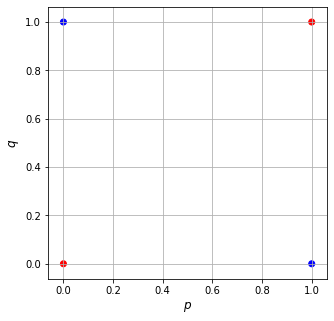

In [18]:
X = np.array([[0,0],[0,1],[1,0],[1,1]])
Y = np.array([[0, 1, 1, 0]])

color= ['blue' if y == 1 else 'red' for y in np.squeeze(Y)]

plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], color=color)
plt.grid()
plt.xlabel(r'$p$', fontsize=12)
plt.ylabel(r'$q$', fontsize=12)

plt.show()

X = X.T #Transponemos X para que quede de dimension (nx, m)

In [7]:
#Definamos los W en cada caso
np.random.seed(2)
W1 = np.random.random([2,2])
b1 = np.zeros([2,1])
W2 = np.random.random([1,2])
b2 = np.zeros([1,1])

In [12]:
def sigmoid(Z):
    A = 1. / (1. + np.exp(-Z))  
    return A

In [13]:
#Feed-Forward: implementamos el ciclo explicitamente
Z1 = np.dot(W1,X) + b1
A1 = sigmoid(Z1)
Z2 = np.dot(W2, A1) + b2
A2 = sigmoid(Z2)

print("Salida de la red para 4 datos: ", A2)

Salida de la red para 4 datos:  [[0.59275141 0.60191942 0.61413859 0.6220829 ]]


In [28]:
#Este proceso se puede automatizar utilizando alguna estructura de datos, por ejemplo, diccionarios

layers = {"layer1":{"W":W1, "b":b1}, "layer2":{"W":W2, "b":b2}} #parametros de la red neuronal
pred = {"layer0":{"A":X}} #diccionario para guardar los Z y A en cada iteracion del feed-forward

for i in range(1, len(layers)+1):
    layer = layers["layer"+str(i)]
    pred["layer"+str(i)] = {}
    
    #Recuperamos datos de la iteracion anterior
    W = layer["W"]
    b = layer["b"]
    A_prev = pred["layer"+str(i-1)]["A"]
    
    #Feed-forward
    Z = np.dot(W, A_prev) + b
    A = sigmoid(Z)
    
    #Salvamos los datos de esta iteracion
    pred["layer"+str(i)]["Z"] = Z
    pred["layer"+str(i)]["A"] = A

print("Salida de la red para 4 datos: ", pred["layer2"]["A"])

Salida de la red para 4 datos:  [[0.59275141 0.60191942 0.61413859 0.6220829 ]]


<hr>

## 3.3. Backpropagation + update

Backpropagation o retro-propagación del error consiste en aplicar el descenso del gradiente sobre una red neuronal con una __arquitectura arbitraria__, utilizando para ello la regla de la cadena sobre el gráfo de cómputo de la red para obtener las derivadas parciales de cada parámetro a partir del error en la salida.

<img align="center" src="https://github.com/psatencio/intro_keras/blob/master/figures/backprop_general.png?raw=true" width="500"/>

Se define de forma general mediante las siguientes instrucciones:

<br>

<font size=3>
$
\\
para(i:l \rightarrow 1)\{
\\
\hspace{10mm} dZ^{[i]} = \left\{\begin{matrix} si(i==l) & A^{[i]} - Y \\ sino & W^{[i+1]T}.dZ^{[i+1]} \end{matrix}\right.
\\
\hspace{10mm} dW^{[i]} = \frac{(dZ^{[i]}.A^{[i-1]T})}{m}
\\
\hspace{10mm} db^{[i]} = \frac{\sum{(dZ^{[i]})}}{m}
\\
\}
$

$
\\
para(i:1 \rightarrow l)\{
\\
\hspace{10mm} W^{[i]} = W^{[i]} - \alpha dW^{[i]}
\\
\hspace{10mm} b^{[i]} = b^{[i]} - \alpha db^{[i]}
\\
\}
$
</font>

In [ ]:
X, Y = generate_data('moons', 0.1)
Y = Y.reshape(1,len(Y))

color = ['blue' if y == 1 else 'red' for y in np.squeeze(Y)] # una lista para darle color a las clases

plt.figure(figsize=(7,5))
plt.scatter(X[:,0], X[:,1], color=color)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid()

plt.show()

<hr>

Revisemos el operador y trabajemos sobre sus tablas de verdad:

<br>

<center><font size=5>$p \oplus q = (p \wedge \neg q) \vee (\neg p \wedge q) $</font></center>

In [ ]:
X1 = np.array([[0,0],[0,1],[1,0],[1,1]])
Y1 = np.array([[0, 1, 1, 1]])

X2 = np.array([[0,0],[0,1],[1,0],[1,1]])
Y2 = np.array([[1, 1, 1, 0]])

X3 = np.array([[0,1],[1,1],[1,1],[1,0]])
Y3 = np.array([[0, 1, 1, 0]])

color1 = ['blue' if y == 1 else 'red' for y in np.squeeze(Y1)]
color2 = ['blue' if y == 1 else 'red' for y in np.squeeze(Y2)]
color3 = ['blue' if y == 1 else 'red' for y in np.squeeze(Y3)]

plt.figure(figsize=(15,4))

plt.subplot(131)
plt.title(r'L = $(p \wedge \neg q)$')
plt.scatter(X1[:,0], X1[:,1], color=color1)
plt.grid()
plt.xlabel(r'$p$', fontsize=12)
plt.ylabel(r'$q$', fontsize=12)

plt.subplot(132)
plt.title(r'$R = (\neg p \wedge q)$')
plt.scatter(X2[:,0], X2[:,1], color=color2)
plt.grid()
plt.xlabel(r'$p$', fontsize=12)
plt.ylabel(r'$q$', fontsize=12)

plt.subplot(133)
plt.title(r'$L \vee R$')
plt.scatter(X3[:,0], X3[:,1], color=color3)
plt.grid()
plt.xlabel(r'$L$', fontsize=12)
plt.ylabel(r'$R$', fontsize=12)

plt.show()

<hr>

El análisis anterior permite suponer que es posible entonces utilizar tres regresores logísticos para aprender cada una de las tres operaciones anteriores y concatenarlos de tal forma que permitan predecir el operador XOR a partir de las entradas.

Para ello, entrenaremos cada regresor por separado utilizando las tablas de verdad construidas en cada caso y finalmente los concatenaremos en una sola estructura como se puede observar en la siguiente figura:

<img align="center" src="https://github.com/psatencio/intro_keras/blob/master/figures/layered_regresor.png?raw=true" width="500"/>

<br>

Analicemos el siguiente código:

In [3]:
#Utilicemos las mismas operaciones vectorizadas para los regresores logisticos.

def linear_activation(W, b, X):
    z = np.dot(W.T,X) + b
    
    return z

def sigmoid(z):
    a = 1. / (1. + np.exp(-z)) 
    
    return a 

def logloss(y, a):
    return -(y * np.log(a) + (1-y) * np.log(1-a))

def cost(L):
    return np.mean(L)

In [4]:
# Datasets, 1 por regresor

X1 = np.array([[0,0],[0,1],[1,0],[1,1]]).T
Y1 = np.array([[0, 1, 1, 1]])

X2 = np.array([[0,0],[0,1],[1,0],[1,1]]).T
Y2 = np.array([[1, 1, 1, 0]])

X3 = np.array([[0,1],[1,1],[1,1],[1,0]]).T
Y3 = np.array([[0, 1, 1, 0]])

In [ ]:
# Parametros de los regresores 1, 2 y 3
np.random.seed(2)

m = len(X1)
nx = X1.shape[0]

W1 = np.random.random([nx, 1]) 
b1 = np.random.random()

W2 = np.random.random([nx, 1]) 
b2 = np.random.random()

W3 = np.random.random([nx, 1])
b3 = np.random.random()

# Parametros del descenso del gradiente
num_epochs = 1000
learning_rate = 0.1

for i in range(num_epochs):
    # Computacion de las activaciones de cada regresor
    Z1 = linear_activation(W1,b1,X1)
    A1 = sigmoid(Z1)
    
    Z2 = linear_activation(W2,b2,X2)
    A2 = sigmoid(Z2)
    
    Z3 = linear_activation(W3,b3,X3)
    A3 = sigmoid(Z3)
    
    # Calculo de gradientes
    dZ1 = A1 - Y1
    dW1 = np.dot(X1, dZ1.T) / m
    db1 = np.sum(dZ1) / m
    
    dZ2 = A2 - Y2
    dW2 = np.dot(X2, dZ2.T) / m
    db2 = np.sum(dZ2) / m
    
    dZ3 = A3 - Y3
    dW3 = np.dot(X3, dZ3.T) / m
    db3 = np.sum(dZ3) / m
    
    # Actualizacion de parametros
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W3 -= learning_rate * dW3
    b3 -= learning_rate * db3
    
    # Estimacion del costo
    J1 = cost(logloss(Y1,A1))
    J2 = cost(logloss(Y2,A2))
    J3 = cost(logloss(Y3,A3))

print("W1 actualizado: ",W1, "b1 actualizado: ", b1, " Costo final: ", J1)
print("W2 actualizado: ",W2, "b2 actualizado: ", b2, " Costo final: ", J2)
print("W3 actualizado: ",W3, "b3 actualizado: ", b3, " Costo final: ", J3)

<hr>

Si bien ahora tenemos nuestros regresor entrenados de manera independiente, debemos conectarlos para poder predecir el valor de salida desde la entrada a los regresores 1 y 2, posteriormente concatenar ambas salidas como entradas para el regresor 3.

In [ ]:
def predict_multilayer(W1,b1,W2,b2,W3,b3,X):
    Z1 = linear_activation(W1,b1,X)
    A1 = sigmoid(Z1)
    
    Z2 = linear_activation(W2,b2,X)
    A2 = sigmoid(Z2)
    
    X3 = np.concatenate((A1,A2), axis=0) #En este punto concatenamos A1 y A2 como entradas para el regresor 3
    Z3 = linear_activation(W3, b3, X3)
    A3 = sigmoid(Z3)
    
    return A3

In [ ]:
visualize_lr(W1, b1, W2, b2, W3, b3, X, Y) #Grafiquemos el mapa de separacion de nuestros regresores en cadena.

<hr>

<font size=4>
    
__Analicemos__: 

Si bien este ejercicio muestra que un conjunto de regresores en cadena puede aproximar problemas no-lineales, finalmente, esta aproximación de entrenamiento es inviable en cualquier caso. En qué radica dicha inviabilidad?

</font>